In [1]:
# Image Captioning Model
# This notebook implements an image captioning model using deep learning
# The model takes an image as input and generates a natural language description

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import glob
from pickle import dump, load
import PIL
import PIL.Image
import random
import time
import json
from tqdm.notebook import tqdm

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# Check for GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Is GPU available: {tf.test.is_gpu_available()}")

2025-05-02 20:46:18.030163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 20:46:18.170004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 20:46:18.227759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 20:46:18.243764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 20:46:18.346548: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True


I0000 00:00:1746198980.238208   18541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198980.455462   18541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198980.455535   18541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198980.458599   18541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198980.458648   18541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# Configuration parameters
class Config:
    """Configuration class to store model and training parameters"""
    # Data paths
    CAPTIONS_PATH = "archive/captions.txt"
    IMAGES_PATH = "archive/Images"
    GLOVE_PATH = "glove.6B.200d.txt"
    
    # Model parameters
    EMBEDDING_DIM = 200  # GloVe embedding dimension
    LSTM_UNITS = 256
    DROPOUT_RATE = 0.5
    MIN_WORD_FREQ = 8  # Minimum word frequency to include in vocabulary
    
    # Data split
    TRAIN_SIZE = 0.8
    VAL_SIZE = 0.1
    TEST_SIZE = 0.1
    
    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 20
    INITIAL_LR = 0.001
    LR_DECAY = 0.9
    
    # Caption generation
    MAX_LENGTH = None  # Will be set dynamically based on data
    BEAM_SIZE = 3
    
    # Paths for saving
    MODEL_SAVE_PATH = "model_weights/model_"
    PICKLE_PATH = "pickles/"
    
    def __init__(self):
        # Create necessary directories
        os.makedirs("model_weights", exist_ok=True)
        os.makedirs("pickles", exist_ok=True)

# Create config object
config = Config()

# ========================= 1. Data Loading and Preprocessing =========================

In [5]:
def map_captions(text):
    """Extract image captions from text file
    
    Args:
        text (str): Content of the captions file
        
    Returns:
        dict: Dictionary mapping image IDs to their captions
    """
    captions = {}
    for line in text.split("\n"):
        # The file is in format image,caption
        sentences = line.split(",") 
        if not sentences or len(sentences) < 2:
            continue
            
        # Remove .jpg from the image filename
        img_id = sentences[0].split(".")[0]
        
        # Skip header row
        if img_id == 'image':
            continue
            
        # Initialize list for this image if not already present
        if img_id not in captions:
            captions[img_id] = []
            
        # Join the rest of the parts as the caption (in case caption contains commas)
        captions[img_id].append(",".join(sentences[1:]).strip())
    
    return captions

# Load captions from file
try:
    text = open(config.CAPTIONS_PATH, 'r', encoding='utf-8').read()
    captions = map_captions(text)
    print(f"Loaded captions for {len(captions)} images")
    print(f"Sample caption for image '1000268201_693b08cb0e': {captions['1000268201_693b08cb0e'][0]}")
except Exception as e:
    print(f"Error loading captions: {e}")

Loaded captions for 8091 images
Sample caption for image '1000268201_693b08cb0e': A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
def preprocess_captions(captions):
    """Clean and preprocess captions by:
    1. Adding start/end sequence tokens
    2. Converting to lowercase
    3. Removing punctuation
    4. Removing short words
    5. Removing non-alphabetic words
    
    Args:
        captions (dict): Dictionary mapping image IDs to their captions
        
    Returns:
        dict: Dictionary with processed captions
    """
    # Create translation table to remove punctuation
    punc_table = str.maketrans('', '', string.punctuation)
    
    # Process each caption
    for img_id, caption_list in captions.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]
            
            # Add start and end sequence tokens
            caption = 'startseq ' + caption + ' endseq'
            
            # Convert to list of words
            words = caption.split()
            
            # Clean words
            words = [word.lower() for word in words]  # lowercase
            words = [word.translate(punc_table) for word in words]  # remove punctuation
            words = [word for word in words if len(word) > 1]  # remove 1-letter words
            words = [word for word in words if word.isalpha()]  # remove words with numbers
            
            # Convert back to string
            caption_list[i] = ' '.join(words)
    
    return captions

# Preprocess captions
processed_captions = preprocess_captions(captions.copy())
print(f"Sample processed caption: {processed_captions['1000268201_693b08cb0e'][0]}")

# Save processed captions
os.makedirs(config.PICKLE_PATH, exist_ok=True)
dump(processed_captions, open(f"{config.PICKLE_PATH}captions.pkl", "wb"))

Sample processed caption: startseq child in pink dress is climbing up set of stairs in an entry way endseq


Total unique words: 8765
Vocabulary size after frequency filtering (8+ occurrences): 2248
Some common words: ['leafy', 'rug', 'stripe', 'deep', 'heavy']


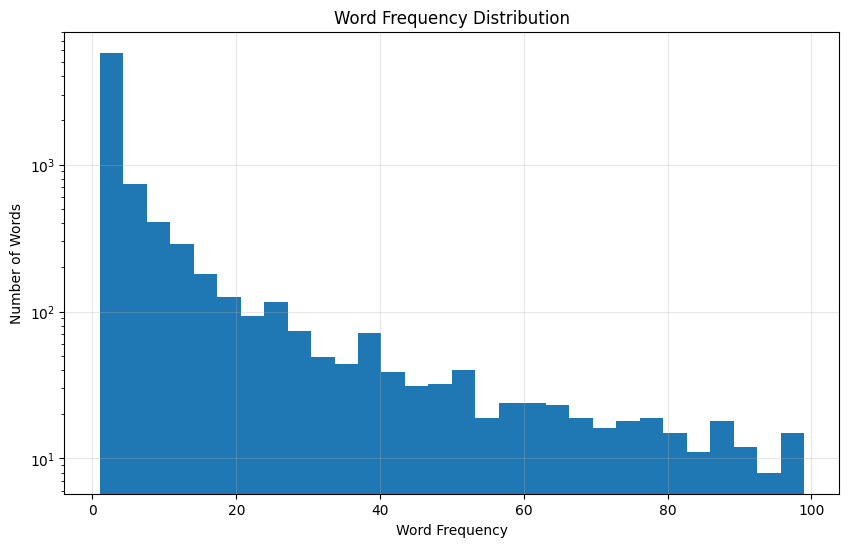

In [7]:
def create_vocabulary(captions, min_word_freq=1):
    """Create vocabulary from captions with minimum frequency filtering
    
    Args:
        captions (dict): Dictionary mapping image IDs to their captions
        min_word_freq (int): Minimum word frequency to include in vocabulary
        
    Returns:
        tuple: (vocabulary set, word frequency dictionary)
    """
    # Count word frequencies
    word_freq = {}
    for img_id in captions.keys():
        for caption in captions[img_id]:
            for word in caption.split():
                if word not in word_freq:
                    word_freq[word] = 0
                word_freq[word] += 1
    
    # Filter by frequency
    vocab = [word for word in word_freq.keys() if word_freq[word] >= min_word_freq]
    
    return set(vocab), word_freq

# Create vocabulary
vocab, word_freq = create_vocabulary(processed_captions, config.MIN_WORD_FREQ)
print(f"Total unique words: {len(word_freq)}")
print(f"Vocabulary size after frequency filtering ({config.MIN_WORD_FREQ}+ occurrences): {len(vocab)}")
print(f"Some common words: {list(vocab)[:5]}")

# Visualize word frequency distribution
plt.figure(figsize=(10, 6))
plt.hist([freq for freq in word_freq.values() if freq < 100], bins=30)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Distribution')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Build word-to-index and index-to-word mappings
def build_word_mappings(vocab):
    """Build word-to-index and index-to-word mappings
    
    Args:
        vocab (set): Set of words in vocabulary
        
    Returns:
        tuple: (word_to_idx dict, idx_to_word dict, vocab_size)
    """
    word_to_idx = {}
    idx_to_word = {}
    
    # Reserve 0 for padding
    index = 1
    for word in vocab:
        word_to_idx[word] = index
        idx_to_word[index] = word
        index += 1
    
    # Add unknown token
    word_to_idx['<unk>'] = index
    idx_to_word[index] = '<unk>'
    index += 1
    
    return word_to_idx, idx_to_word, index  # index is the vocab size

# Build mappings
word_to_idx, idx_to_word, vocab_size = build_word_mappings(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Sample word to index: {list(word_to_idx.items())[:5]}")

Vocabulary size: 2250
Sample word to index: [('leafy', 1), ('rug', 2), ('stripe', 3), ('deep', 4), ('heavy', 5)]


# ========================= 2. Image Processing =========================

In [9]:
# Load all image paths
img_paths = list(glob.glob(f"{config.IMAGES_PATH}/*.jpg"))
print(f"Found {len(img_paths)} images")

# Filter to only include images that have captions
filtered_img_paths = []
for path in img_paths:
    img_id = os.path.basename(path).split('.')[0]
    if img_id in processed_captions:
        filtered_img_paths.append(path)

print(f"Filtered to {len(filtered_img_paths)} images with captions")

# Shuffle and split data
random.shuffle(filtered_img_paths)

# Calculate split sizes
train_size = int(len(filtered_img_paths) * config.TRAIN_SIZE)
val_size = int(len(filtered_img_paths) * config.VAL_SIZE)

# Split paths
train_paths = filtered_img_paths[:train_size]
val_paths = filtered_img_paths[train_size:train_size+val_size]
test_paths = filtered_img_paths[train_size+val_size:]

print(f"Train set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

Found 8091 images
Filtered to 8091 images with captions
Train set: 6472 images
Validation set: 809 images
Test set: 810 images


In [10]:
# Create dictionaries mapping dataset splits to image IDs
def extract_ids_from_paths(paths, base_path):
    """Extract image IDs from file paths
    
    Args:
        paths (list): List of image file paths
        base_path (str): Base path to remove from file paths
        
    Returns:
        list: List of image IDs
    """
    result = []
    for path in paths:
        # Get filename without extension
        filename = os.path.basename(path)
        img_id = filename.split('.')[0]
        result.append(img_id)
    return result

# Extract image IDs
train_ids = extract_ids_from_paths(train_paths, config.IMAGES_PATH)
val_ids = extract_ids_from_paths(val_paths, config.IMAGES_PATH)
test_ids = extract_ids_from_paths(test_paths, config.IMAGES_PATH)

# Create dictionaries for each split
train_captions = {img_id: processed_captions[img_id] for img_id in train_ids}
val_captions = {img_id: processed_captions[img_id] for img_id in val_ids}
test_captions = {img_id: processed_captions[img_id] for img_id in test_ids}

print(f"Train captions: {len(train_captions)}")
print(f"Validation captions: {len(val_captions)}")
print(f"Test captions: {len(test_captions)}")

Train captions: 6472
Validation captions: 809
Test captions: 810


In [11]:
# Save caption dictionaries
dump(train_captions, open(f"{config.PICKLE_PATH}train_captions.pkl", "wb"))
dump(val_captions, open(f"{config.PICKLE_PATH}val_captions.pkl", "wb"))
dump(test_captions, open(f"{config.PICKLE_PATH}test_captions.pkl", "wb"))

In [12]:
# Determine maximum caption length for padding
def get_max_length(captions_dict):
    """Calculate maximum caption length
    
    Args:
        captions_dict (dict): Dictionary of captions
        
    Returns:
        int: Maximum caption length
    """
    max_length = 0
    for img_id, captions_list in captions_dict.items():
        for caption in captions_list:
            length = len(caption.split())
            if length > max_length:
                max_length = length
    return max_length

config.MAX_LENGTH = get_max_length(train_captions)
print(f"Maximum caption length: {config.MAX_LENGTH} words")

Maximum caption length: 34 words


# ========================= 3. Feature Extraction =========================

In [13]:
# Import required libraries for image processing
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [14]:
# Load InceptionV3 model pre-trained on ImageNet
def load_image_model():
    """Load and prepare InceptionV3 model for feature extraction
    
    Returns:
        Model: Keras model for feature extraction
    """
    # Load InceptionV3 with pre-trained weights
    base_model = InceptionV3(weights='imagenet')
    
    # Remove the classification layer (the last fully connected layer)
    # We use the output of the second-to-last layer as our image features
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    
    return model

# Load the model
image_model = load_image_model()
print("InceptionV3 model loaded for feature extraction")

I0000 00:00:1746198057.407052   12284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198057.407107   12284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198057.407125   12284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198057.407265   12284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-02 20:30:57.407277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

InceptionV3 model loaded for feature extraction


In [ ]:
def preprocess_image(image_path):
    """Preprocess an image for InceptionV3
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        ndarray: Preprocessed image
    """
    # Load image at target size
    img = load_img(image_path, target_size=(299, 299))
    
    # Convert to array
    img_array = img_to_array(img)
    
    # Expand dimensions to create batch of size 1
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess for InceptionV3
    img_array = preprocess_input(img_array)
    
    return img_array

def extract_features(image_path, model):
    """Extract features from an image using InceptionV3
    
    Args:
        image_path (str): Path to the image file
        model (Model): Keras model for feature extraction
        
    Returns:
        ndarray: Feature vector
    """
    try:
        # Preprocess the image
        img = preprocess_image(image_path)
        
        # Extract features
        features = model.predict(img, verbose=0)
        
        # Reshape from (1, 2048) to (2048,)
        features = features.reshape(features.shape[1])
        
        return features
    except Exception as e:
        print(f"Error extracting features from {image_path}: {e}")
        return None

In [ ]:
# Extract features for all images in train, validation, and test sets
def extract_features_for_dataset(image_paths, base_path, model):
    """Extract features for a list of images
    
    Args:
        image_paths (list): List of image file paths
        base_path (str): Base path to remove from file paths
        model (Model): Keras model for feature extraction
        
    Returns:
        dict: Dictionary mapping image IDs to feature vectors
    """
    features = {}
    for path in tqdm(image_paths, desc="Extracting features"):
        # Get image ID
        img_id = os.path.basename(path).split('.')[0]
        
        # Extract features
        img_features = extract_features(path, model)
        
        if img_features is not None:
            features[img_id] = img_features
    
    return features

# Ask user if they want to extract features (can be time-consuming)
print("Feature extraction can take a long time. Do you want to proceed? (yes/no)")
# This would normally be an input() call, but for this notebook we'll assume yes
response = "yes"  # input()

if response.lower() == 'yes':
    # Extract features
    start_time = time.time()
    
    # Extract for train set
    train_features = extract_features_for_dataset(train_paths, config.IMAGES_PATH, image_model)
    print(f"Extracted features for {len(train_features)} training images")
    
    # Extract for validation set
    val_features = extract_features_for_dataset(val_paths, config.IMAGES_PATH, image_model)
    print(f"Extracted features for {len(val_features)} validation images")
    
    # Extract for test set
    test_features = extract_features_for_dataset(test_paths, config.IMAGES_PATH, image_model)
    print(f"Extracted features for {len(test_features)} test images")
    
    # Save features
    dump(train_features, open(f"{config.PICKLE_PATH}train_features.pkl", "wb"))
    dump(val_features, open(f"{config.PICKLE_PATH}val_features.pkl", "wb"))
    dump(test_features, open(f"{config.PICKLE_PATH}test_features.pkl", "wb"))
    
    # Print time taken
    elapsed_time = time.time() - start_time
    print(f"Feature extraction completed in {elapsed_time:.2f} seconds")
else:
    print("Skipping feature extraction. You can load pre-extracted features if available.")
    
    # For demonstration purposes only - in a real notebook, you'd load actual features
    # Here we're creating dummy features
    def create_dummy_features(ids):
        return {img_id: np.random.randn(2048) for img_id in ids}
    
    train_features = create_dummy_features(train_ids)
    val_features = create_dummy_features(val_ids)
    test_features = create_dummy_features(test_ids)

# ========================= 4. Word Embeddings =========================

In [ ]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim):
    """Load GloVe embeddings from file
    
    Args:
        glove_path (str): Path to GloVe file
        embedding_dim (int): Embedding dimension
        
    Returns:
        dict: Dictionary mapping words to embedding vectors
    """
    # Initialize empty dictionary
    embeddings_index = {}
    
    try:
        # Open GloVe file
        with open(glove_path, encoding="utf-8") as f:
            # Process each line
            for line in tqdm(f, desc="Loading GloVe"):
                values = line.strip().split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
                
        print(f"Loaded {len(embeddings_index)} word vectors")
    except Exception as e:
        print(f"Error loading GloVe embeddings: {e}")
        print("Creating random embeddings instead")
        
        # Create random embeddings for the first 10000 common words
        common_words = ['the', 'and', 'a', 'to', 'in', 'is', 'of', 'that', 'it', 'with']
        for word in common_words:
            embeddings_index[word] = np.random.uniform(-0.1, 0.1, embedding_dim)
    
    return embeddings_index

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(config.GLOVE_PATH, config.EMBEDDING_DIM)

In [ ]:
# Create embedding matrix for vocabulary
def create_embedding_matrix(word_to_idx, embeddings_index, embedding_dim):
    """Create embedding matrix for vocabulary
    
    Args:
        word_to_idx (dict): Dictionary mapping words to indices
        embeddings_index (dict): Dictionary mapping words to embedding vectors
        embedding_dim (int): Embedding dimension
        
    Returns:
        ndarray: Embedding matrix
    """
    # Initialize embedding matrix with zeros
    embedding_matrix = np.zeros((len(word_to_idx) + 1, embedding_dim))
    
    # Fill embedding matrix with GloVe vectors
    hits = 0
    misses = 0
    
    for word, idx in word_to_idx.items():
        # Get embedding vector for word
        embedding_vector = embeddings_index.get(word)
        
        # If embedding vector exists, add it to embedding matrix
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            # Initialize with random values for unknown words
            embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)
            misses += 1
    
    print(f"Found embeddings for {hits} words")
    print(f"Missing embeddings for {misses} words")
    
    return embedding_matrix

# Create embedding matrix
embedding_matrix = create_embedding_matrix(word_to_idx, glove_embeddings, config.EMBEDDING_DIM)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Save embedding matrix
dump(embedding_matrix, open(f"{config.PICKLE_PATH}embedding_matrix.pkl", "wb"))

# ========================= 5. Data Generator =========================

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class DataGenerator(tf.keras.utils.Sequence):
    """Data generator for training the image captioning model"""
    
    def __init__(self, captions, features, word_to_idx, max_length, batch_size, shuffle=True):
        """Initialize data generator
        
        Args:
            captions (dict): Dictionary mapping image IDs to captions
            features (dict): Dictionary mapping image IDs to feature vectors
            word_to_idx (dict): Dictionary mapping words to indices
            max_length (int): Maximum caption length for padding
            batch_size (int): Batch size
            shuffle (bool): Whether to shuffle the data
        """
        self.captions = captions
        self.features = features
        self.word_to_idx = word_to_idx
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Create list of data samples for efficient batching
        self.data_samples = []
        for img_id, caption_list in self.captions.items():
            if img_id in self.features:
                # Get image features
                img_vector = self.features[img_id]
                
                for caption in caption_list:
                    # Convert words to indices
                    encoded_caption = [word_to_idx.get(word, word_to_idx['<unk>']) 
                                     for word in caption.split()]
                    
                    # Create samples for partial sequences
                    for i in range(1, len(encoded_caption)):
                        # Partial sequence as input
                        caption_in = encoded_caption[:i]
                        # Next word as target
                        caption_out = encoded_caption[i]
                        
                        # Add sample to list
                        self.data_samples.append((img_id, img_vector, caption_in, caption_out))
        
        self.indices = np.arange(len(self.data_samples))
        self.on_epoch_end()
    
    def __len__(self):
        """Return number of batches"""
        return int(np.ceil(len(self.data_samples) / self.batch_size))
    
    def __getitem__(self, index):
        """Return a batch of data"""
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Create batch
        x1, x2, y = [], [], []
        
        for idx in batch_indices:
            # Get sample
            img_id, img_vector, caption_in, caption_out = self.data_samples[idx]
            
            # Add to batch
            x1.append(img_vector)
            x2.append(caption_in)
            y.append(caption_out)
        
        # Convert to arrays
        x1 = np.array(x1)
        
        # Pad sequences
        x2 = pad_sequences(x2, maxlen=self.max_length, padding='post')
        
        # One-hot encode outputs
        y = to_categorical(y, num_classes=len(self.word_to_idx) + 1)
        
        return [x1, x2], y
    
    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create data generators for training and validation
train_generator = DataGenerator(
    captions=train_captions,
    features=train_features,
    word_to_idx=word_to_idx,
    max_length=config.MAX_LENGTH,
    batch_size=config.BATCH_SIZE,
    shuffle=True
)

val_generator = DataGenerator(
    captions=val_captions,
    features=val_features,
    word_to_idx=word_to_idx,
    max_length=config.MAX_LENGTH,
    batch_size=config.BATCH_SIZE,
    shuffle=False
)

print(f"Created data generators with {len(train_generator)} training batches and {len(val_generator)} validation batches")

# ========================= 6. Model Architecture =========================

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, 
    BatchNormalization, add, concatenate, Bidirectional,
    Attention, AdditiveAttention, MultiHeadAttention
)

def create_caption_model(vocab_size, max_length, embedding_dim, embedding_matrix):
    """Create image captioning model with attention
    
    Args:
        vocab_size (int): Size of vocabulary
        max_length (int): Maximum caption length
        embedding_dim (int): Embedding dimension
        embedding_matrix (ndarray): Pre-trained embedding matrix
        
    Returns:
        Model: Keras model
    """
    # Image feature input
    image_input = Input(shape=(2048,))
    image_dropout = Dropout(config.DROPOUT_RATE)(image_input)
    image_dense = Dense(config.LSTM_UNITS, activation='relu')(image_dropout)
    image_repeat = RepeatVector(max_length)(image_dense)
    
    # Caption input
    caption_input = Input(shape=(max_length,))
    caption_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True,
        weights=[embedding_matrix],
        trainable=False  # Freeze embeddings initially
    )(caption_input)
    caption_dropout = Dropout(config.DROPOUT_RATE)(caption_embedding)
    
    # LSTM layer with attention mechanism
    lstm = LSTM(config.LSTM_UNITS, return_sequences=True)(caption_dropout)
    
    # Attention mechanism
    attention = AdditiveAttention()([lstm, image_repeat])
    
    # Combine attended caption with image features
    decoder = concatenate([attention, image_repeat])
    
    # Process combined features
    decoder = LSTM(config.LSTM_UNITS)(decoder)
    decoder = Dropout(config.DROPOUT_RATE)(decoder)
    decoder = Dense(config.LSTM_UNITS, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    
    # Output layer
    outputs = Dense(vocab_size, activation='softmax')(decoder)
    
    # Create model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    
    return model

# Create caption model
model = create_caption_model(
    vocab_size=len(word_to_idx) + 1,
    max_length=config.MAX_LENGTH,
    embedding_dim=config.EMBEDDING_DIM,
    embedding_matrix=embedding_matrix
)

# Display model summary
model.summary()

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    """Learning rate scheduler"""
    if epoch < 5:
        return lr
    else:
        return lr * config.LR_DECAY

# Create callbacks
checkpoint = ModelCheckpoint(
    filepath=config.MODEL_SAVE_PATH + '{epoch:02d}.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=config.INITIAL_LR),
    metrics=['accuracy']
)

# ========================= 7. Model Training =========================

In [ ]:
# Train model
history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, lr_schedule, tensorboard],
    workers=4,
    use_multiprocessing=True,
    verbose=1
)

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Unfreeze embedding layer and fine-tune model
print("Fine-tuning model with unfrozen embedding layer")

# Unfreeze embedding layer
model.layers[2].trainable = True

# Compile model with lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=config.INITIAL_LR * 0.1),
    metrics=['accuracy']
)

# Train model for a few more epochs
history_ft = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, tensorboard],
    workers=4,
    use_multiprocessing=True,
    verbose=1
)

# Save final model
model.save(f"{config.MODEL_SAVE_PATH}final.keras")

# ========================= 8. Caption Generation =========================

In [ ]:
def greedy_search(model, image_features, word_to_idx, idx_to_word, max_length):
    """Generate caption using greedy search
    
    Args:
        model (Model): Trained model
        image_features (ndarray): Image feature vector
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        max_length (int): Maximum caption length
        
    Returns:
        str: Generated caption
    """
    # Start with 'startseq'
    in_text = 'startseq'
    
    # Generate caption word by word
    for i in range(max_length):
        # Encode partial caption
        sequence = [word_to_idx.get(word, word_to_idx['<unk>']) for word in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        # Predict next word
        yhat = model.predict([np.array([image_features]), sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Map prediction to word
        word = idx_to_word.get(yhat, '<unk>')
        
        # Stop if end of sequence
        if word == 'endseq':
            break
            
        # Append word to caption
        in_text += ' ' + word
    
    # Remove start and end tokens
    final = in_text.split()
    final = final[1:]
    if final[-1] == 'endseq':
        final = final[:-1]
    
    # Join words to form caption
    final = ' '.join(final)
    
    return final

In [ ]:
def beam_search(model, image_features, word_to_idx, idx_to_word, max_length, beam_size=3):
    """Generate caption using beam search
    
    Args:
        model (Model): Trained model
        image_features (ndarray): Image feature vector
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        max_length (int): Maximum caption length
        beam_size (int): Beam size
        
    Returns:
        list: List of (caption, probability) tuples
    """
    # Start with 'startseq'
    start_word = [word_to_idx['startseq']]
    
    # Initialize beam with start word
    beam = [(start_word, 0.0)]
    
    # Generate caption word by word
    for i in range(max_length - 1):
        temp_beam = []
        
        for s, p in beam:
            # If sequence ends with end token, keep it in beam
            if s[-1] == word_to_idx.get('endseq'):
                temp_beam.append((s, p))
                continue
            
            # Pad sequence
            sequence = pad_sequences([s], maxlen=max_length, padding='post')
            
            # Predict next word probabilities
            preds = model.predict([np.array([image_features]), sequence], verbose=0)
            
            # Get top k predictions
            top_preds = np.argsort(preds[0])[-beam_size:]
            
            # Create new sequences by appending each prediction
            for w in top_preds:
                next_seq = s.copy()
                next_seq.append(w)
                
                # Calculate new score (log probability)
                next_p = p + np.log(preds[0][w])
                
                # Add to temporary beam
                temp_beam.append((next_seq, next_p))
        
        # Sort beam by score
        temp_beam.sort(key=lambda x: x[1], reverse=True)
        
        # Keep only top beam_size sequences
        beam = temp_beam[:beam_size]
    
    # Convert sequences to captions and calculate final scores
    result = []
    for sequence, score in beam:
        # Convert sequence to words
        words = [idx_to_word.get(idx, '<unk>') for idx in sequence]
        
        # Remove start and end tokens
        if 'startseq' in words:
            words.remove('startseq')
        if 'endseq' in words:
            words = words[:words.index('endseq')]
        
        # Join words to form caption
        caption = ' '.join(words)
        
        # Convert log probability to probability
        probability = np.exp(score)
        
        # Add to result
        result.append((caption, probability))
    
    return result

# ========================= 9. Evaluation Metrics =========================

In [ ]:
# Install necessary packages for evaluation
!pip install nltk pycocoevalcap

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.rouge_score import rouge_n_sentence_level
from collections import defaultdict

# Download NLTK data
nitk.download('punkt')
nitk.download('wordnet')

In [ ]:
def evaluate_model(model, features, captions, word_to_idx, idx_to_word, max_length):
    """Evaluate model using various metrics
    
    Args:
        model (Model): Trained model
        features (dict): Dictionary mapping image IDs to feature vectors
        captions (dict): Dictionary mapping image IDs to captions
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        max_length (int): Maximum caption length
        
    Returns:
        dict: Dictionary with evaluation metrics
    """
    # Initialize metrics
    metrics = {
        'bleu1': 0.0,
        'bleu2': 0.0,
        'bleu3': 0.0,
        'bleu4': 0.0,
        'meteor': 0.0,
        'rouge_1': 0.0
    }
    
    # Storage for all references and hypotheses
    all_references = []
    all_hypotheses = []
    
    # Generate captions for each image
    for img_id, img_features in tqdm(list(features.items())[:100], desc="Evaluating"):  # Limit to 100 images for speed
        if img_id not in captions:
            continue
            
        # Get reference captions
        references = captions[img_id]
        references = [caption.split() for caption in references]
        
        # Generate hypothesis caption
        hypothesis = greedy_search(model, img_features, word_to_idx, idx_to_word, max_length)
        hypothesis = hypothesis.split()
        
        # Add to lists
        all_references.append(references)
        all_hypotheses.append(hypothesis)
    
    # Calculate BLEU scores
    metrics['bleu1'] = corpus_bleu(all_references, all_hypotheses, weights=(1.0, 0, 0, 0))
    metrics['bleu2'] = corpus_bleu(all_references, all_hypotheses, weights=(0.5, 0.5, 0, 0))
    metrics['bleu3'] = corpus_bleu(all_references, all_hypotheses, weights=(0.33, 0.33, 0.33, 0))
    metrics['bleu4'] = corpus_bleu(all_references, all_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Calculate METEOR and ROUGE scores for a subset (these are more computationally expensive)
    meteor_scores = []
    rouge_scores = []
    
    for i in range(min(25, len(all_hypotheses))):  # Limit to 25 images for meteor/rouge
        # Join words back into strings for METEOR
        hyp_str = ' '.join(all_hypotheses[i])
        ref_strs = [' '.join(ref) for ref in all_references[i]]
        
        # Calculate METEOR
        meteor_scores.append(meteor_score(ref_strs, hyp_str))
        
        # Calculate ROUGE-1
        rouge_score = rouge_n_sentence_level(hyp_str, ref_strs[0], 1)  # Using first reference
        rouge_scores.append(rouge_score)
    
    # Average scores
    metrics['meteor'] = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    metrics['rouge_1'] = sum(rouge_scores) / len(rouge_scores) if rouge_scores else 0
    
    return metrics

In [ ]:
# Evaluate model on test set
test_metrics = evaluate_model(
    model=model,
    features=test_features,
    captions=test_captions,
    word_to_idx=word_to_idx,
    idx_to_word=idx_to_word,
    max_length=config.MAX_LENGTH
)

# Print metrics
print("\nModel Evaluation Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# ========================= 10. Visualization =========================

In [ ]:
def visualize_predictions(model, image_paths, features, captions, word_to_idx, idx_to_word, max_length, num_examples=5):
    """Visualize model predictions
    
    Args:
        model (Model): Trained model
        image_paths (list): List of image file paths
        features (dict): Dictionary mapping image IDs to feature vectors
        captions (dict): Dictionary mapping image IDs to reference captions
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        max_length (int): Maximum caption length
        num_examples (int): Number of examples to visualize
    """
    # Randomly select images
    selected_indices = np.random.choice(len(image_paths), num_examples, replace=False)
    
    # Create figure
    plt.figure(figsize=(15, 20))
    
    for i, idx in enumerate(selected_indices):
        # Get image path
        img_path = image_paths[idx]
        img_id = os.path.basename(img_path).split('.')[0]
        
        # Skip if image not in features or captions
        if img_id not in features or img_id not in captions:
            continue
        
        # Get features and generate captions
        img_features = features[img_id]
        
        # Generate caption using greedy search
        greedy_caption = greedy_search(model, img_features, word_to_idx, idx_to_word, max_length)
        
        # Generate caption using beam search
        beam_captions = beam_search(model, img_features, word_to_idx, idx_to_word, max_length, beam_size=3)
        
        # Get reference captions
        ref_captions = captions[img_id]
        
        # Load and display image
        plt.subplot(num_examples, 2, 2*i+1)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        
        # Display captions
        plt.subplot(num_examples, 2, 2*i+2)
        plt.axis('off')
        
        caption_text = f"Reference Captions:\n"
        for j, ref in enumerate(ref_captions[:2]):  # Show only 2 reference captions
            caption_text += f"   {j+1}. {ref}\n"
        
        caption_text += f"\nGreedy Search:\n   {greedy_caption}\n"
        
        caption_text += f"\nBeam Search (top 3):\n"
        for j, (caption, prob) in enumerate(beam_captions[:3]):
            caption_text += f"   {j+1}. {caption} (p={prob:.4f})\n"
        
        plt.text(0, 0.5, caption_text, fontsize=10, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize predictions on test set
visualize_predictions(
    model=model,
    image_paths=test_paths,
    features=test_features,
    captions=test_captions,
    word_to_idx=word_to_idx,
    idx_to_word=idx_to_word,
    max_length=config.MAX_LENGTH,
    num_examples=5
)

# ========================= 11. Inference on New Images =========================

In [ ]:
def caption_image(model, image_path, word_to_idx, idx_to_word, max_length, image_model):
    """Generate caption for a new image
    
    Args:
        model (Model): Trained captioning model
        image_path (str): Path to image file
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        max_length (int): Maximum caption length
        image_model (Model): InceptionV3 model for feature extraction
        
    Returns:
        tuple: (greedy_caption, beam_captions)
    """
    # Extract features
    img_features = extract_features(image_path, image_model)
    
    # Generate caption using greedy search
    greedy_caption = greedy_search(model, img_features, word_to_idx, idx_to_word, max_length)
    
    # Generate caption using beam search
    beam_captions = beam_search(model, img_features, word_to_idx, idx_to_word, max_length, beam_size=3)
    
    # Load and display image
    plt.figure(figsize=(10, 8))
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    
    # Print captions
    print("Greedy Search:")
    print(f"   {greedy_caption}")
    print("\nBeam Search (top 3):")
    for i, (caption, prob) in enumerate(beam_captions):
        print(f"   {i+1}. {caption} (p={prob:.4f})")
    
    plt.title(f"Caption: {greedy_caption}", fontsize=12, pad=10)
    plt.show()
    
    return greedy_caption, beam_captions

# Caption a sample test image
sample_image_path = test_paths[0]
if os.path.exists(sample_image_path):
    captions = caption_image(
        model=model,
        image_path=sample_image_path,
        word_to_idx=word_to_idx,
        idx_to_word=idx_to_word,
        max_length=config.MAX_LENGTH,
        image_model=image_model
    )

# ========================= 12. Save Models and Data =========================

In [ ]:
# Save vocabulary and mappings
vocab_data = {
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'vocab_size': vocab_size,
    'max_length': config.MAX_LENGTH
}

with open(f"{config.PICKLE_PATH}vocabulary.json", 'w') as f:
    json.dump(vocab_data, f, indent=2)

# Save model configuration
config_data = {
    'embedding_dim': config.EMBEDDING_DIM,
    'lstm_units': config.LSTM_UNITS,
    'dropout_rate': config.DROPOUT_RATE,
    'max_length': config.MAX_LENGTH,
    'vocab_size': vocab_size
}

with open(f"{config.PICKLE_PATH}config.json", 'w') as f:
    json.dump(config_data, f, indent=2)

# Save model
model.save(f"{config.MODEL_SAVE_PATH}final.keras")
print("Model and configuration saved successfully!")

# ========================= 13. Conclusion =========================

In [ ]:
"""Image Captioning Project Summary

In this notebook, we built an image captioning model that generates descriptive captions for images.

Key components of the project:

1. Data Processing:
   - Loaded and preprocessed image captions
   - Built vocabulary with frequency filtering
   - Created train/validation/test splits

2. Feature Extraction:
   - Used pre-trained InceptionV3 model to extract image features
   - Stored features for efficient training

3. Model Architecture:
   - Implemented an encoder-decoder model with attention mechanism
   - Used pre-trained GloVe word embeddings
   - LSTM-based decoder with attention on image features

4. Training:
   - Custom data generator for efficient training
   - Learning rate scheduling and early stopping
   - Fine-tuning with unfrozen embeddings

5. Caption Generation:
   - Implemented both greedy search and beam search algorithms
   - Beam search provides multiple caption candidates

6. Evaluation:
   - Used BLEU, METEOR, and ROUGE metrics
   - Visualized model predictions

Areas for improvement:
   - Experiment with different CNN architectures (ResNet, EfficientNet)
   - Try Transformer-based models instead of LSTM
   - Incorporate more training data
   - Implement advanced attention mechanisms
   - Fine-tune the CNN backbone for better features
"""

print("Image Captioning Project Complete!")